This code was developed on run on https://colab.research.google.com/. Running it locally can be challenging due to memory issues. Written by Kalle Nordling.

In [19]:
! pip install xarray==0.16 zarr gcsfs cftime nc-time-axis intake-esm

In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import fsspec
import gcsfs


In [21]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_tas = df[(df.table_id.isin(['Amon'])) & (df.variable_id.isin(['tas'])) & df.experiment_id.isin(['historical','ssp119','ssp585','ssp126']) & (df.member_id == 'r1i1p1f1') ]
#df_tas = df[(df.table_id.isin(['Amon'])) & (df.variable_id.isin(['tasmax','tas','tasmin']))]
df_tas

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
866,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
11914,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp119,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
15886,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
19008,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
...,...,...,...,...,...,...,...,...,...,...,...
517658,ScenarioMIP,CSIRO,ACCESS-ESM1-5,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1...,NaN,20210318
521076,CMIP,KIOST,KIOST-ESM,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/KIOST/KIOST-ESM/historic...,NaN,20210601
521159,ScenarioMIP,KIOST,KIOST-ESM,ssp126,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/s...,NaN,20210601
521172,ScenarioMIP,KIOST,KIOST-ESM,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM/s...,NaN,20210601


In [22]:
a=df_tas[df_tas.experiment_id == "ssp126"].source_id.values
b=df_tas[df_tas.experiment_id == "ssp585"].source_id.values
models=np.intersect1d(a,b)
models=list(models)
models.remove('ACCESS-CM2')
models.remove('ACCESS-ESM1-5')
df_tas = df[(df.table_id.isin(['Amon'])) & (df.variable_id.isin(['tas'])) & df.experiment_id.isin(['historical','ssp119','ssp585','ssp126']) & (df.member_id == 'r1i1p1f1') & df.source_id.isin(models) ]
df_tas[df_tas.experiment_id == "ssp119"].source_id.values

array(['GFDL-ESM4', 'MRI-ESM2-0', 'IPSL-CM6A-LR', 'CanESM5',
       'CAMS-CSM1-0', 'MIROC6', 'EC-Earth3-Veg', 'FGOALS-g3',
       'EC-Earth3-Veg-LR'], dtype=object)

In [23]:
def load_data(source_id, expt_id,var):
    #get list of urls
    uri = df_tas[(df_tas.source_id == source_id) & (df_tas.experiment_id == expt_id) & (df_tas.variable_id == var)].zstore
    #get list of member_id's
    member_id = df_tas[(df_tas.source_id == source_id) &
                         (df_tas.experiment_id == expt_id) & (df_tas.variable_id == var)].member_id#.values[0]
    #concentrate all members to single xarray dataframe
    dss = []
    for ur in uri.values:
        print(ur)
        mapper=gcs.get_mapper(ur)
        dss.append(xr.open_zarr(mapper, consolidated=True))
    try:
      ds= xr.concat(dss,dim='member_id').assign_coords(source_id=list(member_id))
      return ds
    except:
      return 0
source_ids = df_tas.source_id.unique()
results={}
gcs = gcsfs.GCSFileSystem(token='anon')
for exp in ['historical','ssp126','ssp119','ssp585']:
  results[exp]={}
  for model in source_ids:
    print(model,exp)
    data = load_data(model,exp,'tas')
    if data != 0:
      results[exp][model]=data#load_data(model,exp,'hurs')

GFDL-ESM4 historical
gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/tas/gr1/v20190726/
IPSL-CM6A-LR historical
gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/
BCC-CSM2-MR historical
gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/
MIROC6 historical
gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/
MRI-ESM2-0 historical
gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historical/r1i1p1f1/Amon/tas/gn/v20190222/
CESM2-WACCM historical
gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/Amon/tas/gn/v20190227/
CanESM5 historical
gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/tas/gn/v20190429/
AWI-CM-1-1-MR historical
gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/Amon/tas/gn/v20200720/
INM-CM4-8 historical
gs://cmip6/CMIP6/CMIP/INM/INM-CM4-8/historical/r1i1p1f1/Amon/tas/gr1/v20190530/
INM-CM5-0 historical
gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical/r1i1

In [24]:
results.items()

dict_items([('historical', {'GFDL-ESM4': <xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, member_id: 1, source_id: 1, time: 1980)
Coordinates:
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    height     float64 ...
  * bnds       (bnds) float64 1.0 2.0
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * source_id  (source_id) <U8 'r1i1p1f1'
Dimensions without coordinates: member_id
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 180, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:       

In [25]:
import matplotlib.pyplot as plt

def calcMean(data):
    if data is None:
        return None
    if ('longitude' in data.dims) and ('latitude' in data.dims):
        data = data.rename({'longitude':'lon', 'latitude': 'lat'})
    print(data)
    data = data.sel(lon=slice(20,31),lat=slice(60,71))
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    data_mean= data_weighted.mean(("lon", "lat"))
    return data_mean

gmst_dicts = {}

for exp, dic in results.items():
    tmp = {}
    for model, data in dic.items():
        if model == "ICON-ESM-LR":
          continue
        tmp[model] = calcMean(data)


    gmst_dicts[exp] = tmp

Streaming output truncated to the last 5000 lines.
Dimensions without coordinates: bnds, member_id
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 126, 256, 512), meta=np.ndarray>
Attributes:
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time_in_child:               0.0
    branch_time_in_parent:              29219.0
    cmor_version:                       3.4.0
    contact:                            cmip6-data@ec-earth.org
    creation_date:                      2019-06-05T10:16:58Z
    data_specs_version:                 01.00.30
    experiment:                         all-forcing simulation of the recent ...
    experiment_id:                      historical
    external_variables:                 areacella
    forcing_index:                      1
    frequency:                          mon
    further_info_url:             

In [26]:
gmst_dicts

{'historical': {'GFDL-ESM4': <xarray.Dataset>
  Dimensions:  (member_id: 1, time: 1980)
  Coordinates:
      height   float64 2.0
    * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  Dimensions without coordinates: member_id
  Data variables:
      tas      (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>,
  'IPSL-CM6A-LR': <xarray.Dataset>
  Dimensions:  (member_id: 1, time: 1980)
  Coordinates:
      height   float64 2.0
    * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  Dimensions without coordinates: member_id
  Data variables:
      tas      (member_id, time) float32 dask.array<chunksize=(1, 600), meta=np.ndarray>,
  'BCC-CSM2-MR': <xarray.Dataset>
  Dimensions:  (member_id: 1, time: 1980)
  Coordinates:
      height   float64 2.0
    * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  Dimensions without coordinates: member_id
  Data variables:
      tas      (member_id, time) float64

In [27]:
gmst_anoms={}
for exp, data in gmst_dicts.items():
    gmst_anoms[exp] = {}
    for model,data in data.items():
      gmst_anoms[exp][model] = (data - (gmst_dicts['historical'][model].groupby('time.year').mean().sel(year=slice('1850','1900')).mean(dim=['year','member_id'])))

In [28]:
gmst_dicts.keys()

dict_keys(['historical', 'ssp126', 'ssp119', 'ssp585'])

In [29]:
def is_amj(month):
    return (month >= 5) & (month <= 9)
glob =  gmst_dicts['historical']
dss = [ds.tas.sel(time=is_amj(ds['time.month'])).groupby('time.year').mean(dim='time') for key, ds in glob.items()]
historical_cmip6= xr.concat(dss,dim='source_id',coords='minimal').assign_coords(source_id=list(glob.keys()))


cmip_data={}

for exp in ['ssp119','ssp585','ssp126']:
    print(exp)
    glob = gmst_dicts[exp]
    dss = [ds.tas.sel(time=is_amj(ds['time.month'])).groupby('time.year').mean(dim='time') for key, ds in glob.items()]
    tmp2= xr.concat(dss,dim='source_id',coords='minimal').assign_coords(source_id=list(glob.keys()))


    models=list(gmst_dicts[exp].keys())
    hist_models=list(gmst_dicts['historical'].keys())
    sel_models=list(set(models).intersection(hist_models))

    hist_sel=historical_cmip6.sel(dict(source_id=sel_models))

    tmp2=tmp2.sel(dict(source_id=sel_models))
    hist_sel=hist_sel.sel(year=slice(1850,2014))
    sce= tmp2.sel(year=slice(2015,2100))
    sce_file=xr.concat([hist_sel,sce],dim='time').sum(dim='time')
    sce_file = sce_file.where(sce_file > 0)
    #sce_file-=273.15
    cmip_data[exp] = sce_file.load()

/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)


ssp119


/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)
/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)


ssp585


/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)
/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)
/usr/local/lib/python3.10/dist-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 30
  result = blockwise(
/usr/local/lib/python3.10/dist-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 30
  result = blockwise(


ssp126


/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)
/usr/local/lib/python3.10/dist-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  index = joiner(matching_indexes)
/usr/local/lib/python3.10/dist-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 30
  result = blockwise(
/usr/local/lib/python3.10/dist-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 30
  result = blockwise(


In [30]:
cmip_data[exp]

<xarray.DataArray 'tas' (source_id: 30, member_id: 1, year: 251)>
array([[[282.54753199, 281.48489698, 283.41621254, ..., 283.75581172,
         284.48077648, 284.33430868]],

       [[282.76944551, 281.67605254, 281.45072575, ..., 284.80413899,
         283.78616935, 282.6938906 ]],

       [[         nan, 283.72201419, 283.37111926, ..., 286.12020221,
         286.48014246, 285.95763962]],

       ...,

       [[282.21476992, 282.01747882, 281.69141135, ..., 284.96780049,
         286.17497944, 285.25297792]],

       [[283.45604719, 281.78213533, 281.45820188, ..., 285.67511751,
         285.7162576 , 285.80230814]],

       [[283.06666898, 281.90663076, 281.95662735, ..., 284.21077524,
         283.15180457, 283.83255984]]])
Coordinates:
    height     float64 2.0
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * source_id  (source_id) <U16 'INM-CM5-0' 'FGOALS-f3-L' ... 'MRI-ESM2-0'
Dimensions without coordinates: member_id

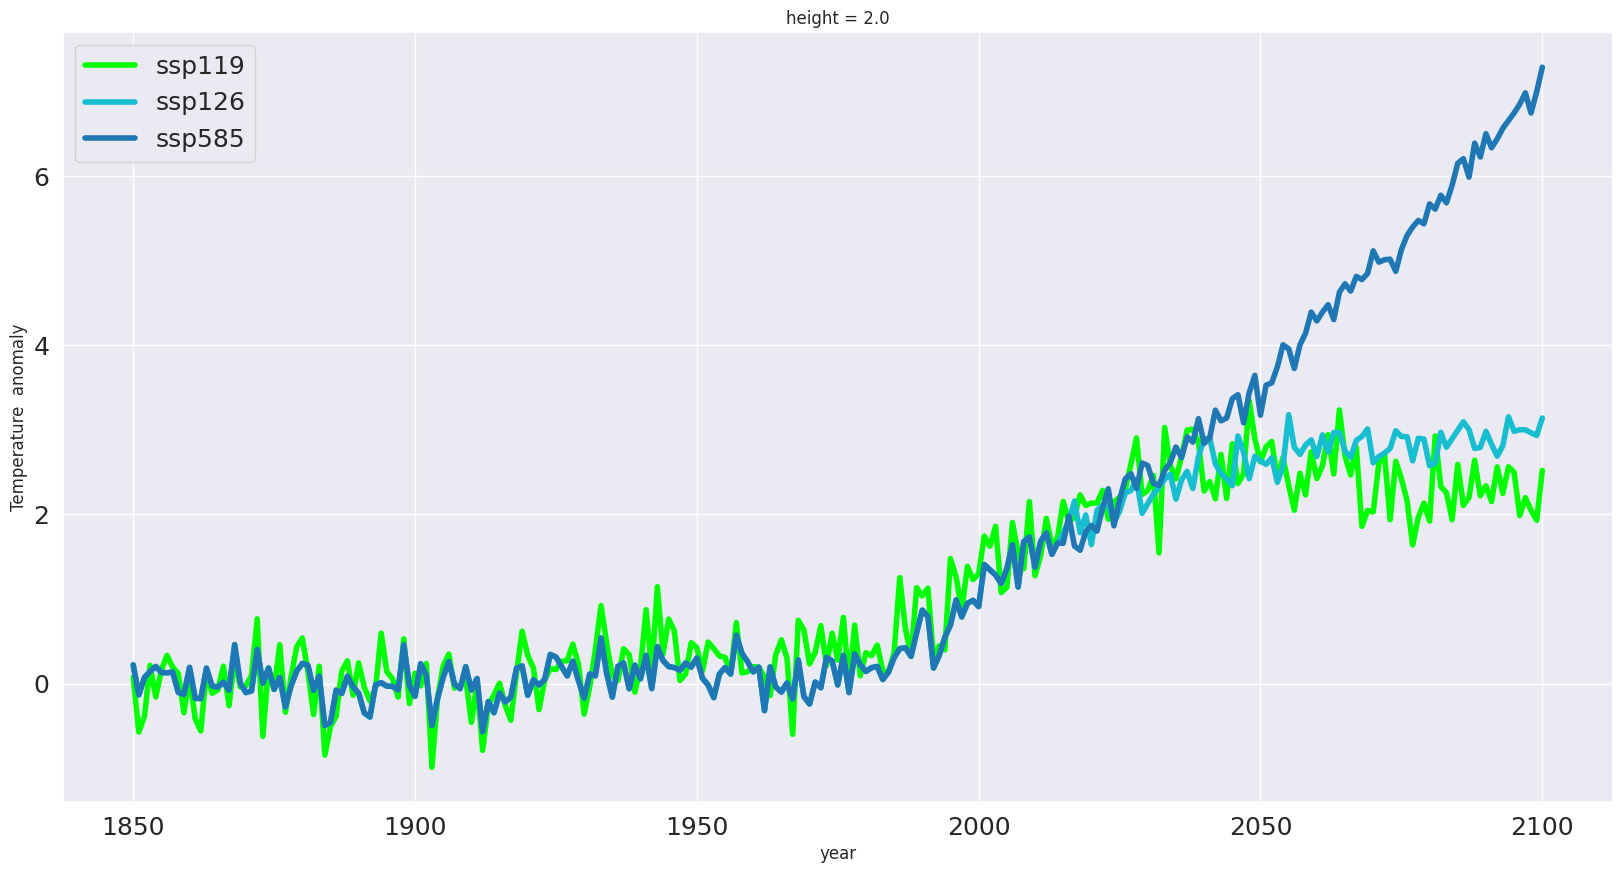

In [31]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
colors = ['lime','tab:cyan', 'tab:blue', 'darkorange', 'tab:red']
for i,exp in enumerate(['ssp119','ssp126','ssp585']):
    tmp = cmip_data[exp]
    tmp=  tmp-(tmp.sel(year=slice('1850','1900')).mean(dim=['year','member_id']))

    data=tmp.isel(member_id=0).mean(dim='source_id')
    data.plot(label=exp,color=colors[i],linewidth=4)

    #for model in list(tmp.source_id):
    #    tmp.isel(member_id=0).sel(year=slice(1900,2020)).sel(source_id=model).plot(color=colors[i],linewidth=1,alpha=0.4)


plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Temperature  anomaly')
plt.show()

In [32]:
from sklearn.linear_model import LinearRegression


def calcTrend(data_in,year,step):
    linear_regressor = LinearRegression()
    stop=year+step
    if stop>2100:
        stop=2100
    X = data_in.sel(year=slice(str(year),str(stop))).year.to_masked_array().reshape(-1, 1)
    Y = data_in.sel(year=slice(str(year),str(stop))).to_masked_array().reshape(-1, 1)
    trend=np.nan
    try:
        linear_regressor.fit(X, Y)  # perform linear regression
        trend=linear_regressor.coef_[0]*10
    except:
        print('trend error')
    return trend

cmip6_trend_ssp={}


for ssp in ['ssp119','ssp126','ssp585']:
    cmip6_trend_ssp[ssp] = {}
    for m in cmip_data[ssp].isel(member_id=0).source_id:
        #try:
            name = str(m.to_masked_array())
            print(name)
            data =cmip_data[ssp].isel(member_id=0).sel(source_id=m)
            cmip6_trend_ssp[ssp][name] = {}
            for y_start in range(2020,2100,30):
                cmip6_trend_ssp[ssp][name][str(y_start)] = calcTrend(data,y_start,30)

#hist trend
cmip6_trend_hist = {}
for ssp in ['ssp585']:
    cmip6_trend_hist[ssp] = {}
    for m in cmip_data[ssp].isel(member_id=0).source_id:
        #try:
            name = str(m.to_masked_array())
            print(name)
            data =cmip_data[ssp].isel(member_id=0).sel(source_id=m)
            cmip6_trend_hist[ssp][name] = calcTrend(data,1980,40)


CAMS-CSM1-0
trend error
FGOALS-g3
EC-Earth3-Veg-LR
IPSL-CM6A-LR
GFDL-ESM4
EC-Earth3-Veg
MRI-ESM2-0
MIROC6
CanESM5
INM-CM5-0
FGOALS-f3-L
AWI-CM-1-1-MR
EC-Earth3-Veg
NorESM2-LM
MIROC6
BCC-CSM2-MR
CanESM5
KACE-1-0-G
CESM2-WACCM
FGOALS-g3
MPI-ESM1-2-HR
EC-Earth3
CMCC-ESM2
INM-CM4-8
CIESM
CMCC-CM2-SR5
NorESM2-MM
MPI-ESM1-2-LR
EC-Earth3-Veg-LR
IPSL-CM6A-LR
KIOST-ESM
GFDL-ESM4
TaiESM1
CAMS-CSM1-0
trend error
IITM-ESM
trend error
FIO-ESM-2-0
NESM3
CAS-ESM2-0
MRI-ESM2-0
INM-CM5-0
FGOALS-f3-L
AWI-CM-1-1-MR
EC-Earth3-Veg
NorESM2-LM
MIROC6
BCC-CSM2-MR
CanESM5
KACE-1-0-G
CESM2-WACCM
FGOALS-g3
MPI-ESM1-2-HR
EC-Earth3
CMCC-ESM2
INM-CM4-8
CIESM
CMCC-CM2-SR5
NorESM2-MM
MPI-ESM1-2-LR
EC-Earth3-Veg-LR
IPSL-CM6A-LR
KIOST-ESM
GFDL-ESM4
TaiESM1
CAMS-CSM1-0
trend error
IITM-ESM
trend error
FIO-ESM-2-0
NESM3
CAS-ESM2-0
MRI-ESM2-0
INM-CM5-0
FGOALS-f3-L
AWI-CM-1-1-MR
EC-Earth3-Veg
NorESM2-LM
MIROC6
BCC-CSM2-MR
CanESM5
KACE-1-0-G
CESM2-WACCM
FGOALS-g3
MPI-ESM1-2-HR
EC-Earth3
CMCC-ESM2
INM-CM4-8
CIESM
CMCC-CM2-SR

[0.38277136 0.19582677 0.58564362 0.65209426 0.55194286 0.38276958
 0.65751557 0.43859399 0.69190293 0.47903752 0.39318992 0.47551585
 1.07491125 0.16881056 0.16102606 0.40666595 0.61715625 0.44796487
 0.16986764 0.70700756 0.38838882 0.42371287 0.37969886 0.47519821
 0.06047435 0.29642767 0.48409654 1.1328662  0.27359368 0.66203103]
[0.38277136 0.19582677 0.58564362 0.65209426 0.55194286 0.38276958
 0.65751557 0.43859399 0.69190293 0.47903752 0.39318992 0.47551585
 1.07491125 0.16881056 0.16102606 0.40666595 0.61715625 0.44796487
 0.16986764 0.70700756 0.38838882 0.42371287 0.37969886 0.47519821
 0.06047435 0.29642767 0.48409654 1.1328662  0.27359368 0.66203103]
[0.38277136 0.19582677 0.58564362 0.65209426 0.55194286 0.38276958
 0.65751557 0.43859399 0.69190293 0.47903752 0.39318992 0.47551585
 1.07491125 0.16881056 0.16102606 0.40666595 0.61715625 0.44796487
 0.16986764 0.70700756 0.38838882 0.42371287 0.37969886 0.47519821
 0.06047435 0.29642767 0.48409654 1.1328662  0.27359368 0.66

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-33-8052673c3e70>:69: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(25)


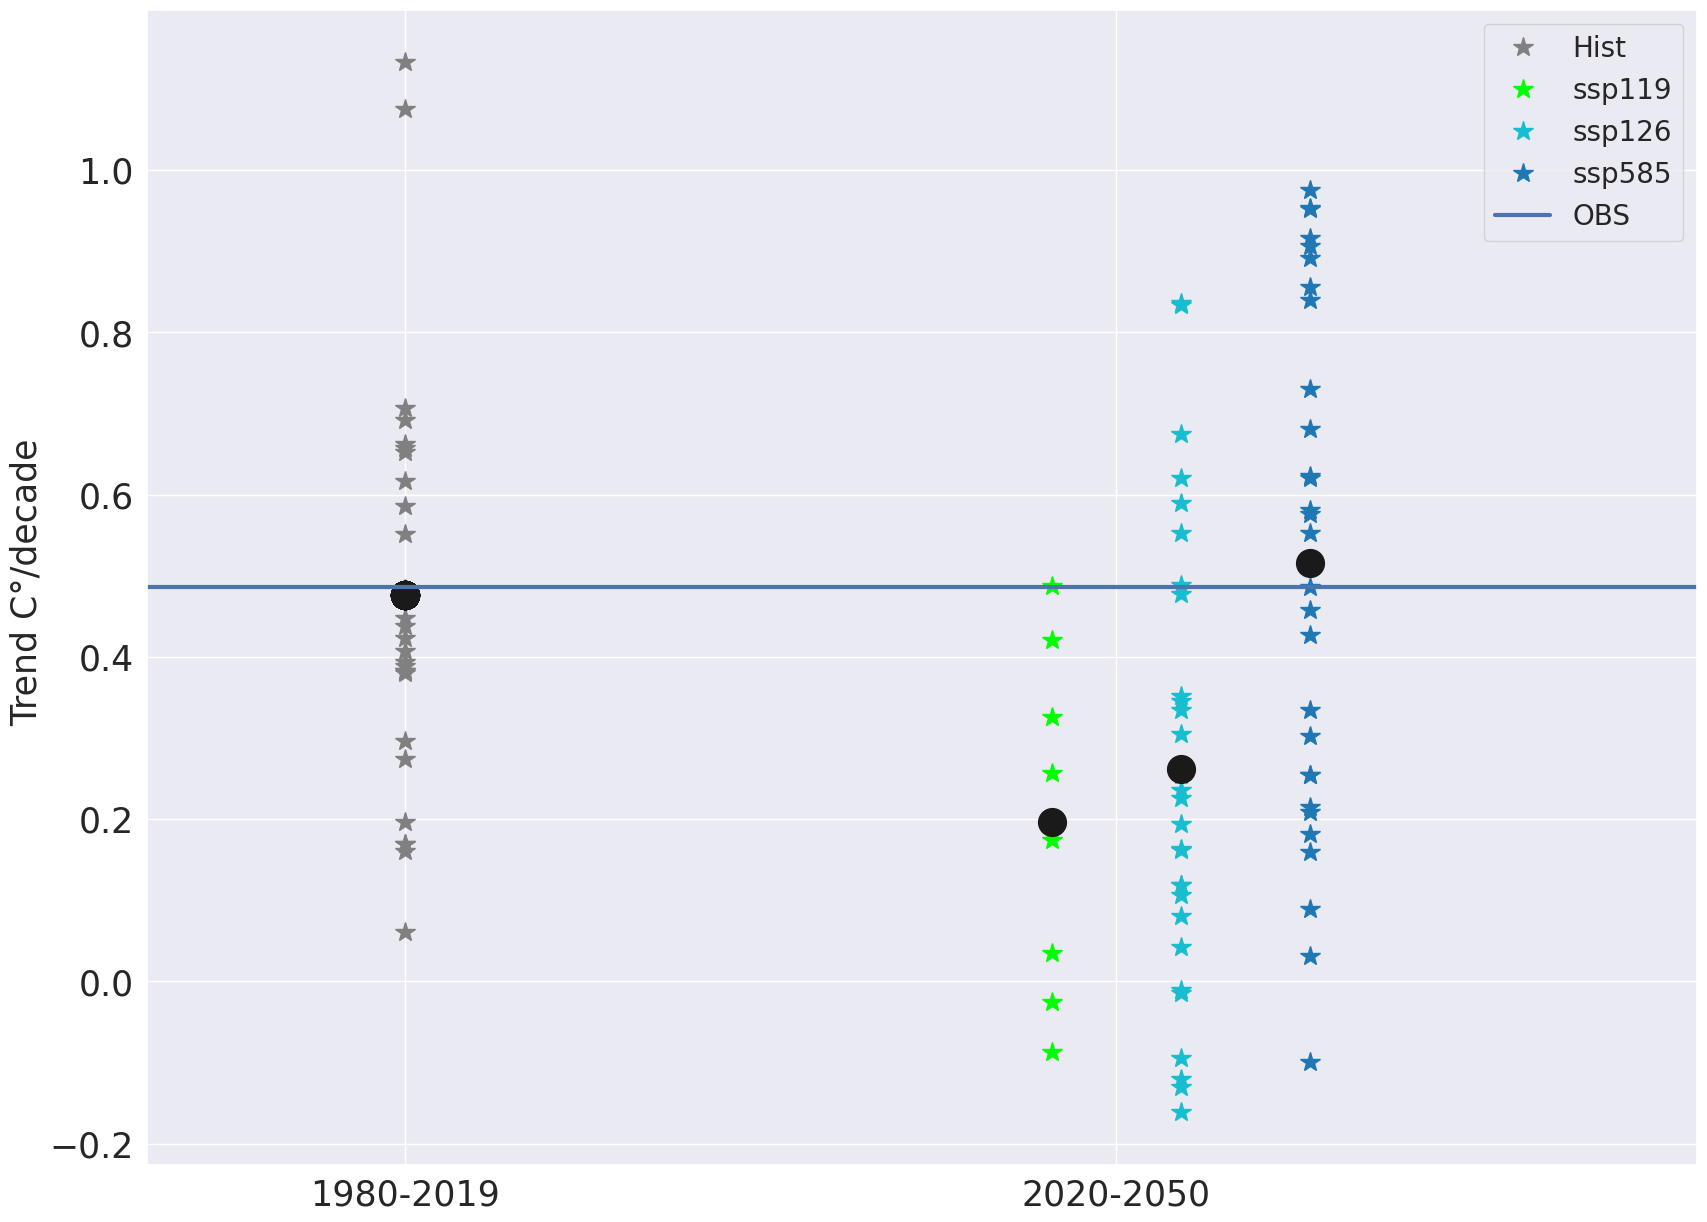

In [33]:
import seaborn as sns

def calcWmean(a,obs):
  a = np. squeeze(a)
  w=1/(np.abs(np.array(a)-obs))
  return np.average(a,weights=w), w

#e=['FGOALS-g3','EC-Earth3-Veg-LR','CAMS-CSM1-0']
sns.set()

plot_x={'2020':1,'2050':2,'2080':3}
plot_x2={'2020':1.25,'2050':2.25,'2080':3.25}
plot_x2={'hist':0.35,'2020':1.0,'2050':2.25,'2080':3.25}
fig,ax = plt.subplots(1,1,figsize=[20,15])

colors = ['lime','tab:cyan', 'tab:blue', 'darkorange', 'tab:red']

cmip6_mean_f={'2020':{'ssp119':[],'ssp126':[],'ssp245':[],'ssp370':[],'ssp585':[]},'2050':{'ssp119':[],'ssp126':[],'ssp245':[],'ssp370':[],'ssp585':[]},'2080':{'ssp119':[],'ssp126':[],'ssp245':[],'ssp370':[],'ssp585':[]}}
cmip6_mean_hist=[]
for i,exp in enumerate(['ssp585']):
    for j,(model,trend) in enumerate(cmip6_trend_hist[exp].items()):
        # if model in exclude:
        #    continue
        if (j == 0):
              ax.plot(plot_x2['hist']+0.15,trend,'*',color='gray',label='Hist',markersize=15)
        else:
              ax.plot(plot_x2['hist']+0.15,trend,'*',color='gray',markersize=15)
        #print(model,trend)
        cmip6_mean_hist.append(trend)

for i,exp in enumerate(['ssp119','ssp126','ssp585']):
    for j,(model,period) in enumerate(cmip6_trend_ssp[exp].items()):
        #print(period)
        #if model in exclude:
        #    continue
        #print(model)
        for k,(pre,trend) in enumerate(period.items()):
            if pre != "2020":
              continue
            if (pre == "2020") and (model=="EC-Earth3-Veg"):
              print('add legend')
              ax.plot(plot_x2[pre]+(i+0.005)*0.1,trend,'*',color=colors[i],label=exp,markersize=15)
            else:
              ax.plot(plot_x2[pre]+(i+0.005)*0.1,trend,'*',color=colors[i],markersize=15)

            cmip6_mean_f[pre][exp].append(trend)

#for pre,mean in cmip6_mean_f.items():
        print(np.squeeze(np.array(cmip6_mean_hist)))
        hist_mean_cmip6, weights=calcWmean(np.array(cmip6_mean_hist),0.486)
        ax.plot(plot_x2['hist']+0.15,hist_mean_cmip6,marker='o',color='k',markersize=20,fillstyle=None)

print('historical trend',np.nanmean(cmip6_mean_hist))
for pre,mean in cmip6_mean_f.items():
    for j,exp in enumerate(['ssp119','ssp126','ssp585']):
        a=np.array(cmip6_mean_f[pre][exp])
        # print(a.shape,weights.shape)
        ax.plot(plot_x2[pre]+(j+0.005)*0.1,np.average(a),marker='o',color='k',markersize=20,fillstyle=None)
        #print(pre,exp,np.nanmean(cmip6_mean_f[pre][exp]))

#ax[0].set_ylim(-1,1)
ax.set_ylabel(' Trend C°/decade' ,fontsize=25)
ax.set_xticks([0.5,1.05])#,2.25,3.35])
ax.set_xticklabels(['1980-2019','2020-2050'],fontsize=25)#,'2050-2080','2080-2100'],fontsize=25)
#ax.set_xticklabels(['2020-2050'],fontsize=25)#,'2050-2080','2080-2100'],fontsize=25)


for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
hist_trend=0.486
ax.plot([-1,2],[hist_trend,hist_trend],linewidth=3,label='OBS')
ax.set_xlim(0.3,1.5)
ax.legend(fontsize=20)
plt.savefig('figure.eps',dpi=1800)
plt.savefig('figure.png')
#ax.set_title('Future warming trends',fontsize=20)

In [34]:
cmip6_mean_hist
print(len(cmip6_trend_ssp['ssp119']))
print(len(cmip6_trend_ssp['ssp126']))
print(len(cmip6_trend_ssp['ssp585']))

output={'historical':[],'ssp119':[],'ssp126':[],'ssp585':[]}
print(len(models))
for model in models:
  output['historical'].append(float(cmip6_trend_hist['ssp585'][model]))
  output['ssp126'].append(float(cmip6_trend_ssp['ssp126'][model]['2020']))
  output['ssp585'].append(float(cmip6_trend_ssp['ssp585'][model]['2020']))

  if model in list(cmip6_trend_ssp['ssp119'].keys()):
      output['ssp119'].append(float(cmip6_trend_ssp['ssp119'][model]['2020']))
  else:
      output['ssp119'].append(np.nan)

df=pd.DataFrame(data=output,index=models)
print(df)
df.to_csv('cmip6_raw_trends.csv')

9
30
30
30
                  historical    ssp119    ssp126    ssp585
GFDL-ESM4           0.379699 -0.087528 -0.119816  0.159288
IPSL-CM6A-LR        0.388389  0.487732  0.589326  0.915794
BCC-CSM2-MR         0.657516       NaN -0.130701  0.839435
MIROC6              0.382770  0.325353  0.345866  0.729977
MRI-ESM2-0          0.662031  0.185013  0.334659  0.620152
CESM2-WACCM         0.479038       NaN  0.833901  0.576101
CanESM5             0.438594  0.420567  0.477748  0.681421
AWI-CM-1-1-MR       0.585644       NaN  0.106744  0.253910
INM-CM4-8           0.161026       NaN  0.163470  0.581168
INM-CM5-0           0.382771       NaN  0.080237  0.254588
NESM3               1.132866       NaN  0.226424  0.208351
CAMS-CSM1-0         0.060474  0.034382  0.119007  0.031697
MPI-ESM1-2-LR       0.169868       NaN -0.010310  0.457703
MPI-ESM1-2-HR       0.475516       NaN  0.042381  0.486570
NorESM2-LM          0.551943       NaN  0.235302  0.088972
FGOALS-g3           0.393190  0.256908  0.489